<a href="https://colab.research.google.com/github/Foco22/Customer_Segment/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# for data preprocessing and clustering
from sklearn.cluster import KMeans

In [16]:
url = 'https://raw.githubusercontent.com/cereniyim/Customer-Segmentation-Unsupervised-ML-Model/0418ed702b0b8f87b472d68971c84a4913fa956e/Orders%20-%20Analysis%20Task.csv'
df = pd.read_csv(url)

df.head()
df.shape

(70052, 17)

In [6]:
df.isnull().sum()

product_title             0
product_type              0
variant_title             0
variant_sku               0
variant_id                0
customer_id               0
order_id                  0
day                       0
net_quantity              0
gross_sales               0
discounts                 0
returns                   0
net_sales                 0
taxes                     0
total_sales               0
returned_item_quantity    0
ordered_item_quantity     0
dtype: int64

In [10]:
df.describe()

,variant_id,customer_id,order_id,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,returned_item_quantity,ordered_item_quantity
count,7.005200e+04,7.005200e+04,7.005200e+04,70052.000000,70052.000000,70052.000000,70052.000000,70052.000000,70052.000000,70052.000000,70052.000000,70052.000000
mean,2.442320e+11,6.013091e+11,5.506075e+13,0.701179,61.776302,-4.949904,-10.246051,46.580348,9.123636,55.703982,-0.156098,0.857277
std,4.255079e+12,6.223201e+12,2.587640e+13,0.739497,31.800689,7.769972,25.154677,51.802690,10.305236,61.920557,0.369190,0.380820
min,1.001447e+07,1.000661e+06,1.000657e+13,-3.000000,0.000000,-200.000000,-237.500000,-237.500000,-47.500000,-285.000000,-3.000000,0.000000
25%,2.692223e+07,3.295695e+06,3.270317e+13,1.000000,51.670000,-8.340000,0.000000,47.080000,8.375000,56.227500,0.000000,1.000000
50%,4.494514e+07,5.566107e+06,5.522207e+13,1.000000,74.170000,0.000000,0.000000,63.330000,12.660000,76.000000,0.000000,1.000000
75%,7.743106e+07,7.815352e+06,7.736876e+13,1.000000,79.170000,0.000000,0.000000,74.170000,14.840000,89.000000,0.000000,1.000000
max,8.422212e+13,9.977409e+13,9.999554e+13,6.000000,445.000000,0.000000,0.000000,445.000000,63.340000,445.000000,0.000000,6.000000


In [73]:
df = df.loc[df["ordered_item_quantity"] > 0]
df.head()

,product_title,product_type,variant_title,variant_sku,variant_id,customer_id,order_id,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,returned_item_quantity,ordered_item_quantity
0,DPR,DPR,100,AD-982-708-895-F-6C894FB,52039657,1312378,83290718932496,04/12/2018,2,200.0,-200.00,0.00,0.0,0.0,0.0,0,2
1,RJF,Product P,28 / A / MTM,83-490-E49-8C8-8-3B100BC,56914686,3715657,36253792848113,01/04/2019,2,190.0,-190.00,0.00,0.0,0.0,0.0,0,2
2,CLH,Product B,32 / B / FtO,68-ECA-BC7-3B2-A-E73DE1B,24064862,9533448,73094559597229,05/11/2018,0,164.8,-156.56,-8.24,0.0,0.0,0.0,-2,2
3,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,53616575668264,19/02/2019,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1
4,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,29263220319421,19/02/2019,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1


In [67]:
def encode_column(column):
    if column > 0:
        return 1
    if column <= 0:
        return 0


def aggregate_by_ordered_quantity(dataframe, column_list):
    '''this function:
    1. aggregates a given dataframe by column list, 
    as a result creates a aggregated dataframe by counting the ordered item quantities

    2. adds number_of_X ordered where X is the second element in the column_list 
    to the aggregated dataframe by encoding ordered items into 1

    3. creates final dataframe containing information about 
    how many of X are ordered, based on the first element passed in the column list'''

    aggregated_dataframe = (dataframe
                            .groupby(column_list)
                            .ordered_item_quantity.count()
                            .reset_index())

    aggregated_dataframe["products_ordered"] = (aggregated_dataframe
                                                 .ordered_item_quantity
                                                 .apply(encode_column))

    final_dataframe = (aggregated_dataframe
                       .groupby(column_list[0])
                       .products_ordered.sum() # aligned with the added column name
                       .reset_index())

    return final_dataframe


customers = aggregate_by_ordered_quantity(df, ["customer_id", "product_type"])
customers.head()

,customer_id,products_ordered
0,1000661,1
1,1001914,1
2,1002167,3
3,1002387,1
4,1002419,2


In [102]:
order_sum_by_clients = df.groupby(['customer_id','order_id']).sum()['ordered_item_quantity'].reset_index()
order_sum_by_clients

return_sum_by_clients = df.groupby(['customer_id','order_id']).sum()['returned_item_quantity'].reset_index()
return_sum_by_clients

ordered_returned_sums = pd.merge(order_sum_by_clients, return_sum_by_clients)
ordered_returned_sums['average_item_return'] = (-1*ordered_returned_sums['returned_item_quantity']/
                                                ordered_returned_sums['ordered_item_quantity'])


ordered_returned_sums.head()

,customer_id,order_id,ordered_item_quantity,returned_item_quantity,average_item_return
0,1000661,99119989117212,3,0,0.0
1,1001914,79758569034715,1,0,0.0
2,1002167,38156088848638,1,0,0.0
3,1002167,57440147820257,1,0,0.0
4,1002167,58825523953710,1,0,0.0


In [106]:
customer_return_rate = ordered_returned_sums.groupby('customer_id').mean()['average_item_return'].reset_index()

customer_return_rate.head()

,customer_id,average_item_return
0,1000661,0.0
1,1001914,0.0
2,1002167,0.0
3,1002387,0.0
4,1002419,0.0


In [107]:
return_rate = pd.DataFrame(customer_return_rate['average_item_return'].value_counts().reset_index())
return_rate

,index,average_item_return
0,0.000000,24823
1,0.333333,13
2,1.000000,13
3,0.500000,9
4,0.250000,5
5,0.166667,2
6,0.200000,2
7,0.666667,2
8,0.083333,1
9,0.013889,1


In [110]:
return_rate.rename(columns=
                    {"index": "average return rate",
                     "average_item_return": "count of unit return rate"},
                    inplace=True)

In [112]:
return_rate.sort_values(by="average return rate")

,average return rate,count of unit return rate
0,0.000000,24823
9,0.013889,1
10,0.066667,1
8,0.083333,1
12,0.125000,1
5,0.166667,2
6,0.200000,2
4,0.250000,5
1,0.333333,13
11,0.400000,1


In [114]:
customers = pd.merge(customers,
                     customer_return_rate,
                     on="customer_id")

,customer_id,products_ordered,average_item_return_x,average_item_return_y
0,1000661,1,0.0,0.0
1,1001914,1,0.0,0.0
2,1002167,3,0.0,0.0
3,1002387,1,0.0,0.0
4,1002419,2,0.0,0.0
...,...,...,...,...
24869,97805007741979,2,0.0,0.0
24870,98854671633650,2,0.0,0.0
24871,98974226154136,1,0.0,0.0
24872,99262726332691,2,0.0,0.0


In [118]:
customers.drop(['average_item_return_y','average_item_return'],inplace =True, axis =1)

In [120]:
return_rate.rename(columns=
                    {"average_item_return_x": "average_item_return"},
                    inplace=True)

In [122]:
customers = pd.merge(customers,
                     customer_return_rate,
                     on="customer_id")

In [127]:
customers.head()

,customer_id,products_ordered,average_item_return_x,average_item_return
0,1000661,1,0.0,0.0
1,1001914,1,0.0,0.0
2,1002167,3,0.0,0.0
3,1002387,1,0.0,0.0
4,1002419,2,0.0,0.0


In [128]:
customer_total_spending = (df.groupby('customer_id').sum()['total_sales']).reset_index()

customer_total_spending.rename(columns = {"total_sales" : "total_spending"},
                               inplace = True)

In [130]:
customers = customers.merge(customer_total_spending, 
                            on="customer_id")

In [132]:
customers.drop(['average_item_return_x'],inplace =True, axis =1)

In [134]:
customers.head()

,customer_id,products_ordered,average_item_return,total_spending
0,1000661,1,0.0,260.0
1,1001914,1,0.0,79.2
2,1002167,3,0.0,234.2
3,1002387,1,0.0,89.0
4,1002419,2,0.0,103.0


In [135]:
customers.drop(columns="customer_id",
               inplace=True)

In [137]:

def apply_log1p_transformation(dataframe, column):
    '''This function takes a dataframe and a column in the string format
    then applies numpy log1p transformation to the column
    as a result returns log1p applied pandas series'''
    
    dataframe["log_" + column] = np.log1p(dataframe[column])
    return dataframe["log_" + column]

In [139]:

apply_log1p_transformation(customers, "products_ordered")
apply_log1p_transformation(customers, "average_item_return")
apply_log1p_transformation(customers, "total_spending")

0        5.564520
1        4.384524
2        5.460436
3        4.499810
4        4.644391
           ...   
24869    5.560682
24870    5.495117
24871    4.499810
24872    5.590987
24873    4.174387
Name: log_total_spending, Length: 24874, dtype: float64

In [141]:
customers.head()

,products_ordered,average_item_return,total_spending,log_products_ordered,log_average_item_return,log_total_spending
0,1,0.0,260.0,0.693147,0.0,5.564520
1,1,0.0,79.2,0.693147,0.0,4.384524
2,3,0.0,234.2,1.386294,0.0,5.460436
3,1,0.0,89.0,0.693147,0.0,4.499810
4,2,0.0,103.0,1.098612,0.0,4.644391


In [142]:
kmeans_model = KMeans(init='k-means++', 
                      max_iter=500, 
                      random_state=42)

In [143]:
kmeans_model.fit(customers.iloc[:,3:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [144]:
def make_list_of_K(K, dataframe):
    '''inputs: K as integer and dataframe
    apply k-means clustering to dataframe
    and make a list of inertia values against 1 to K (inclusive)
    return the inertia values list
    '''
    
    cluster_values = list(range(1, K+1))
    inertia_values=[]
    
    for c in cluster_values:
        model = KMeans(
            n_clusters = c, 
            init='k-means++', 
            max_iter=500, 
            random_state=42)
        model.fit(dataframe)
        inertia_values.append(model.inertia_)
    
    return inertia_values

In [149]:

# save inertia values in a dataframe for k values between 1 to 15 
results = make_list_of_K(30, customers.iloc[:, 3:])

k_values_distances = pd.DataFrame({"clusters": list(range(1, 31)),
                                   "within cluster sum of squared distances": results})



In [150]:

# visualization for the selection of number of segments
fig = go.Figure()

fig.add_trace(go.Scatter(x=k_values_distances["clusters"], 
                         y=k_values_distances["within cluster sum of squared distances"],
                         mode='lines+markers'))

fig.update_layout(xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1),
                  title_text="Within Cluster Sum of Squared Distances VS K Values",
                  xaxis_title="K values",
                  yaxis_title="Cluster sum of squared distances")

fig.show()

In [151]:
updated_kmeans_model = KMeans(n_clusters = 4, 
                              init='k-means++', 
                              max_iter=500, 
                              random_state=42)


In [154]:
prediction = updated_kmeans_model.fit_predict(customers.iloc[:,3:])

In [163]:
customers["clusters"] = updated_kmeans_model.labels_

In [178]:
result = customers[['products_ordered','average_item_return','total_spending','clusters']]
result.groupby('clusters').agg({'sum','mean','count','max'})

products_ordered                ... total_spending                    
                     mean  count    sum  ...          count         sum     max
clusters                                 ...                                   
0                1.018439  10467  10660  ...          10467   824927.85   114.0
1                1.583819   7206  11413  ...           7206  1168834.10   258.1
2                4.122478   2082   8583  ...           2082  1280976.45  3131.7
3                2.471967   5119  12654  ...           5119  1482296.90   570.0

[4 rows x 12 columns]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



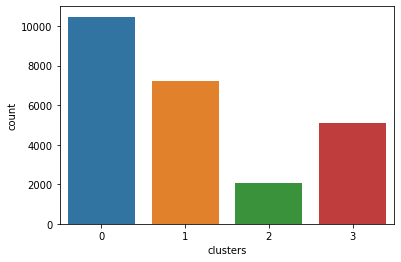

In [172]:
import seaborn as sns

sns.countplot(x='clusters', data=result)

In [184]:
result
grafico = customers[['log_products_ordered','log_average_item_return','log_total_spending']]

,log_products_ordered,log_average_item_return,log_total_spending
0,0.693147,0.0,5.564520
1,0.693147,0.0,4.384524
2,1.386294,0.0,5.460436
3,0.693147,0.0,4.499810
4,1.098612,0.0,4.644391
...,...,...,...
24869,1.098612,0.0,5.560682
24870,1.098612,0.0,5.495117
24871,0.693147,0.0,4.499810
24872,1.098612,0.0,5.590987


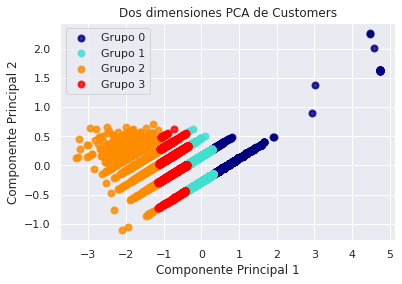

In [200]:
from sklearn import datasets
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#guardar los datos transformados en un arreglo X_r
X_r = pca.fit(grafico).transform(grafico)
# crear una figura
plt.figure()
#definir colores para cada especie de flor iris
colors = ['navy', 'turquoise', 'darkorange','red']
target_name = ['Grupo 0', 'Grupo 1', 'Grupo 2','Grupo 3']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_name):
 plt.scatter(X_r[updated_kmeans_model.labels_ == i, 0], X_r[updated_kmeans_model.labels_ == i, 1], color=color, alpha=.8, lw=2,
 label=target_name)
sns.set()
# configurar el gráfico
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Dos dimensiones PCA de Customers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [199]:
X_r

array([[-0.4317958 , -0.44704242],
       [ 0.66416415, -0.00987379],
       [-0.59201421,  0.23518908],
       ...,
       [ 0.55708844, -0.05258533],
       [-0.60664846, -0.08032497],
       [ 0.85933493,  0.06797809]])

In [198]:
from sklearn.datasets import load_digits
# Importar las librerías con los métodos de reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)

X_embedded = tsne.fit_transform(grafico)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24874 samples in 0.076s...
[t-SNE] Computed neighbors for 24874 samples in 0.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24874
[t-SNE] Computed conditional probabilities for sample 2000 / 24874
[t-SNE] Computed conditional probabilities for sample 3000 / 24874
[t-SNE] Computed conditional probabilities for sample 4000 / 24874
[t-SNE] Computed conditional probabilities for sample 5000 / 24874
[t-SNE] Computed conditional probabilities for sample 6000 / 24874
[t-SNE] Computed conditional probabilities for sample 7000 / 24874
[t-SNE] Computed conditional probabilities for sample 8000 / 24874
[t-SNE] Computed conditional probabilities for sample 9000 / 24874
[t-SNE] Computed conditional probabilities for sample 10000 / 24874
[t-SNE] Computed conditional probabilities for sample 11000 / 24874
[t-SNE] Computed conditional probabilities for sample 12000 / 24874
[t-SNE] Computed conditional probabilities for sam

KeyboardInterrupt: ignored

In [ ]:
plt.scatter( X_embedded[:, 0], X_embedded[:, 1],
 c=updated_kmeans_model.labels_, edgecolor='none', alpha=0.8,
 cmap=plt.cm.get_cmap('tab10', 10) )
plt.title('Reducción de Dimensionalidad t-SNE')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.colorbar()